In [1]:
%matplotlib inline

import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.0.0


In [2]:
"""Loading Data
Description:
    Distributing the Data Accordingly for the traing and testing set.
    and Converts a class vector (integers) to binary class matrix.
    Returns:
    Shape of the Traing and testing Data Set.
"""
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


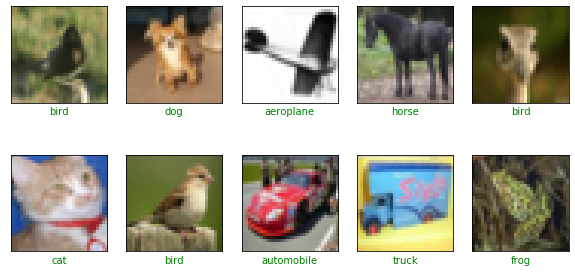

In [3]:
#Classes In the DataSet are as Follow
class_names = ['aeroplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def show_random_examples(x, y, p):
    """To show Random Examples Images.
    Description:
    Example labels and Predictions no of examples that exist and no of examples that we want replace=false which
    means all return values should be unique
    Returns:
    Random Images with thier name a green text means the prediction is true while red means its false.
    """
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_train, y_train, y_train)

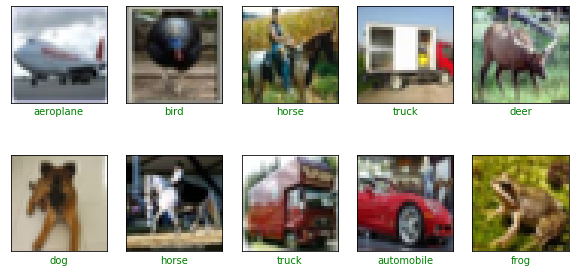

In [4]:
show_random_examples(x_test, y_test, y_test)

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
"one epoch means one cycle of model training where all the training examples in the training set have been used." 
"So, if you are training a model for 10 epochs, it means that you have trained the model on the entire training set 10 times."

#Longer training will often result in better performing models, but if you're satisfied with model performance 
# (by looking at validation loss or accuracy), you don't have to train for any longer.

def create_model():
    """Instantiating CNN MODEL.
        Adds Input Layer and Convenlutional Blocks with 32 ,64,128 filters.
        Description:
        Output of the conv_block will be flatten
    adding dense layer to 10 nodes because of 10 classes and activation function set to softmax for probability distribution
        Returns:
        Compiled model.
    """
    def add_conv_block(model, num_filters):
        """Adding Convenlutional Blocks.
            Two  Convenlutional Blocks one Batch Normalization Block,Pooling and Dropout Layer.
            Description:
            Convenlutional Layer for keeping the row and cloumn same
            This will a regularization affect using it for co varience shift
Another Covenlutional Layer  which won't keep the Row and Column Same so it will be reduced Height and the Width are reduced
            Adding max pooling layer so it will reduce the row and column to have the orignal layer
            Dropout layer for regularization.
            Returns:
            A model With all the block's being added.
        """
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)

    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 15, 64)       

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 293s 6ms/sample - loss: 0.2982 - accuracy: 0.8933 - val_loss: 0.6056 - val_accuracy: 0.8206
Epoch 2/20
50000/50000 [==============================] - 334s 7ms/sample - loss: 0.2891 - accuracy: 0.8961 - val_loss: 0.5952 - val_accuracy: 0.8157
Epoch 3/20
50000/50000 [==============================] - 345s 7ms/sample - loss: 0.2807 - accuracy: 0.9002 - val_loss: 0.5603 - val_accuracy: 0.8301
Epoch 4/20
50000/50000 [==============================] - 319s 6ms/sample - loss: 0.2689 - accuracy: 0.9033 - val_loss: 0.6198 - val_accuracy: 0.8258
Epoch 5/20
50000/50000 [==============================] - 305s 6ms/sample - loss: 0.2610 - accuracy: 0.9066 - val_loss: 0.5997 - val_accuracy: 0.8251


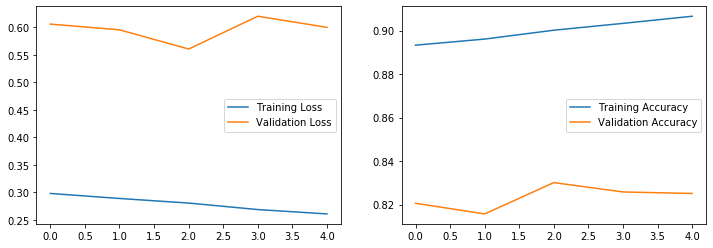

Wall time: 26min 46s


In [8]:
%%time
""" Pass training set so the values are normalized  for Pixels according to the range. So 0-1 Range.
    Description:
1. Call backs so that if the models accuracy doesn't increases for epochs(Patience value) so then stop  training the Data
2. Models Directory to save file according to there accuracy value, Save  Models Only which performed better than the previous
   Model based on epochs
    Returns:
     A Model with Fitted Data.
"""
h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=20, batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ]
)

"""
Get accuracy for each epoc from history
To show that validation accuracy increased during traing

"""
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [10]:
"""Load's Model From The local Folder
    Description:
    Loads The model based on the prefix of the model name the decimal points shows the accuracy of the Model.
    After The model is Loaded do predictions on the model and validate its score against the x_test.
"""
model = tf.keras.models.load_model('models/model_0.830.h5')
preds = model.predict(x_test/255.)

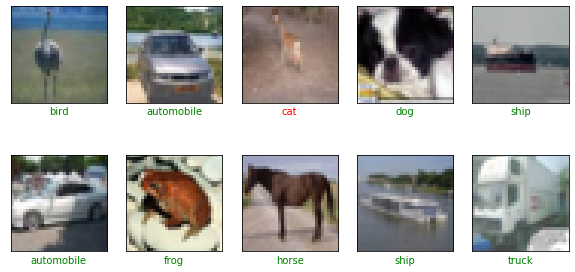

In [21]:
show_random_examples(x_test, y_test, preds)